In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cPickle as pickle

import time

# python packages
import sys
import os
import glob
from socket import gethostname
#from collections import defaultdict

import numpy as np
import numpy.lib.recfunctions
import pandas as pd

# scipy-project imports
import scipy.interpolate
import scipy.optimize
import scipy.stats
from scipy.special import erf, erfinv, erfc

# Misc
from ic_data import load_data, prepare_directory
import ic_utils as utils

# Plotting
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
from matplotlib.colors import LogNorm
mpl = sns.mpl
plt = mpl.pyplot
#plt = utils.plotting("pdf")

from collections import defaultdict
from scipy.interpolate import UnivariateSpline
from skylab.prior_generator import UhecrPriorGenerator

current_time = int(time.time())
print current_time

print ":)"

print "8===D"

1527602215
:)
8===D


In [3]:
print(gethostname())
basepath, inipath, savepath, crpath, figurepath = utils.get_paths(gethostname())
print savepath
print figurepath

cobalt03.icecube.wisc.edu
/data/user/lschumacher/projects/stacking/hotspot_fitting
/home/lschumacher/public_html/uhecr_stacking/hotspot_fit


## Read UHECR data

In [4]:
n_cr = dict()
pg = UhecrPriorGenerator(6)
for e in np.arange(50, 160, 5):
    pg._get_UHECR_positions(e, crpath)
    n_cr[e] = pg.n_uhecr

## Read Background trials

In [7]:
new = True
for md in bg_TS.keys():
    for i,data in enumerate(bg_TS[md]):
        temp = pd.DataFrame(data)
        temp["trial"] = pd.Series(np.full(data.shape, i))
        temp["md"] = pd.Series(np.full(data.shape, md))
        if new:
            bg_frame = temp
            new = False
        else:
            bg_frame = bg_frame.append(temp, ignore_index=True)
temp = None

In [23]:
name = "{}_bg_TS_dataframe.pickle".format(current_time)
print name
bg_frame.drop(labels=["ecut"], axis=1).to_pickle(os.path.join(savepath, name))

1525262555
1525262555_bg_TS_dataframe.pickle


In [5]:
name = sorted(glob.glob(os.path.join(savepath,"*_bg_TS_dataframe.pickle")))
print name

bg_frame = pd.read_pickle(name[-1])

['/data/user/lschumacher/projects/stacking/hotspot_fitting/1525262555_bg_TS_dataframe.pickle']


## Read Signal trials

In [319]:
clen = len(utils.colors)
#timecut = 1522240357
ecuts = [85, 125]
mdparams = [6]
new = True
trial = 0
tempm = []
for md in mdparams:
    print md
    tempe = []
    for ecut in ecuts:
        print " * "*20
        print ecut
        folders = sorted(glob.glob(os.path.join(savepath, "signal_*_shift*_mdparams-{}_ecut-{}*".format(md, ecut))))
        #print folders
        tempframes = []
        for f in folders:
            parts = f.split("_")
            #if int(parts[2])<timecut: continue
            for p in parts:
                if "mu" in p:
                    ID = float(p[3:])
                if "shift-" in p:
                    s = float(p[6:])
            inputfiles = sorted(glob.glob(os.path.join(savepath, f, "job*_hotspots_*.txt")))
            print s
            
            tempframe = []
            for infile in inputfiles:
                data = np.genfromtxt(infile, names=True)
                temp = pd.DataFrame(data)
                temp["mu"] = pd.Series(np.full(data.shape, ID))
                temp["ecut"] = pd.Series(np.full(data.shape, ecut))
                temp["md"] = pd.Series(np.full(data.shape, md))
                temp["trial"] = pd.Series(np.full(data.shape, trial))
                trial += 1
                temp["shift"] = pd.Series(np.full(data.shape, s))
                tempframe.append(temp)
            tempframes.append(pd.concat(tempframe))
        tempe.append(pd.concat(tempframes))
    tempm.append(pd.concat(tempe))
signal_frame = pd.concat(tempm)
print "done"

6
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
85
0.0
3.0
0.0
3.0
0.0
3.0
10.0
5.0
10.0
5.0
10.0
5.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
125
10.0
0.0
10.0
0.0
10.0
0.0
10.0
0.0
10.0
0.0
done


In [320]:
signal_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90980 entries, 0 to 3
Data columns (total 16 columns):
North       90980 non-null float64
South       90980 non-null float64
ra          90980 non-null float64
dec         90980 non-null float64
nsources    90980 non-null float64
gamma       90980 non-null float64
best        90980 non-null float64
ra_inj      90980 non-null float64
dec_inj     90980 non-null float64
n_inj       90980 non-null float64
energy      90980 non-null float64
mu          90980 non-null float64
ecut        90980 non-null int64
md          90980 non-null int64
trial       90980 non-null int64
shift       90980 non-null float64
dtypes: float64(13), int64(3)
memory usage: 11.8 MB


In [321]:
name = "{}_signal_TS_dataframe.pickle".format(current_time)
print name
signal_frame.to_pickle(os.path.join(savepath, name))

1525615272_signal_TS_dataframe.pickle


In [6]:
names = sorted(glob.glob(os.path.join(savepath, "*_signal_TS_dataframe.pickle")))
print names

signal_frame = pd.read_pickle(names[-1])

['/data/user/lschumacher/projects/stacking/hotspot_fitting/1525262555_signal_TS_dataframe.pickle', '/data/user/lschumacher/projects/stacking/hotspot_fitting/1525615272_signal_TS_dataframe.pickle']


## Raw flux for ${n}_{inj}$ -> flux calculation

/home/lschumacher/my_virtualenvs/my_skylab/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


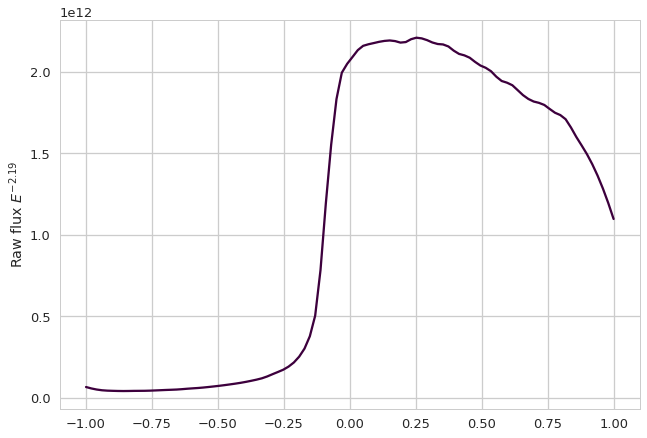

In [7]:
## Flux calculations

sinDec = np.loadtxt(os.path.join(crpath, "sindec_bins_gamma-2.19.npy"))

raw_fluxes = np.loadtxt(os.path.join(crpath, "raw_fluxes_gamma-2.19.npy"))
sum_flux = raw_fluxes.sum(axis=0)

sinDec_x = np.linspace(min(sinDec), max(sinDec), num=100)
flux_spline = scipy.interpolate.InterpolatedUnivariateSpline(
                                (sinDec[1:] + sinDec[:-1]) / 2.,
                                sum_flux/(2*np.pi*(sinDec[1:] - sinDec[:-1])), k=2)

#"""flux_spline
plt.figure()
plt.plot(sinDec_x, flux_spline(sinDec_x))
plt.ylabel(r"Raw flux $E^{-2.19}$")
plt.show()
#"""

In [8]:
raw_fluxes = np.loadtxt("/home/lschumacher/git_repos/general_code_repo/data/raw_fluxes_gamma-2.19.npy")
print raw_fluxes.sum()*1.01*np.power(10,-18.+3+2*2.19)/np.sqrt(7./8.)

360.9037438975409


## Background only

[ 85 125]


<Figure size 748.8x514.8 with 0 Axes>

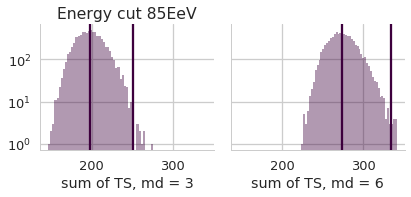

<Figure size 748.8x514.8 with 0 Axes>

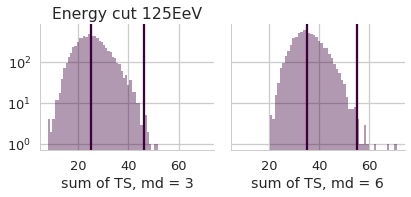

In [126]:
ecuts = signal_frame.ecut.unique()
print ecuts

## only plotting
for ecut in ecuts:
    sns.mpl.pyplot.figure()
    temp = bg_frame.loc[bg_frame.energy>=ecut].groupby(by=["trial", "md"])["best"].sum().reset_index()
    grid = sns.FacetGrid(temp, col="md")
    grid.map(sns.distplot, "best", kde=False)
    grid.map(lambda x, **kwargs: plt.axvline(x.median(), **kwargs), "best")
    grid.map(lambda x, **kwargs: plt.axvline(x.quantile(1.-erfc(3./np.sqrt(2))*0.5), **kwargs), "best")
    for ax in grid.axes.flatten():
        ax.semilogy(nonposy="clip")
        title = ax.get_title()
        ax.set_xlabel("sum of TS, "+title)
    grid.axes.flatten()[0].set_title("Energy cut {}EeV".format(ecut))
    grid.axes.flatten()[1].set_title("")    

## signal only

85
125


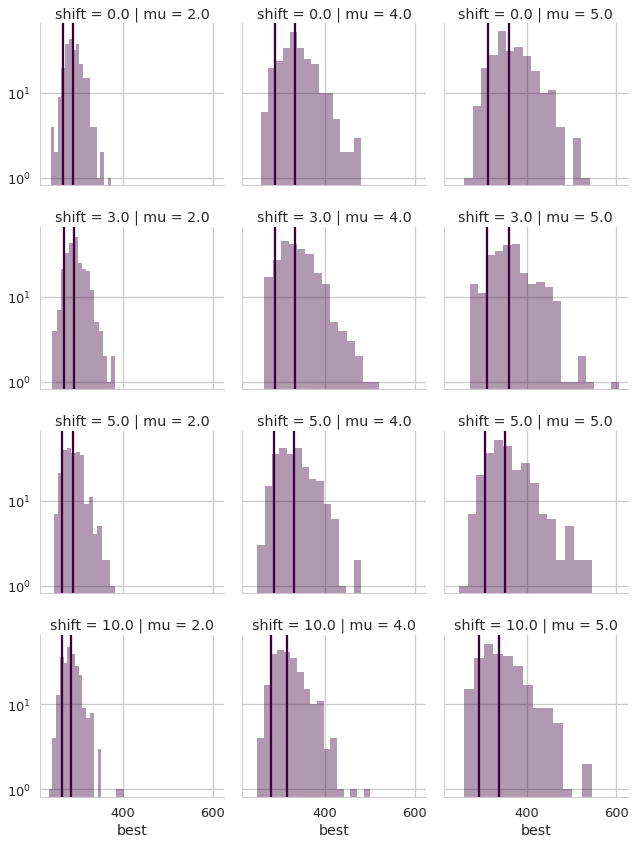

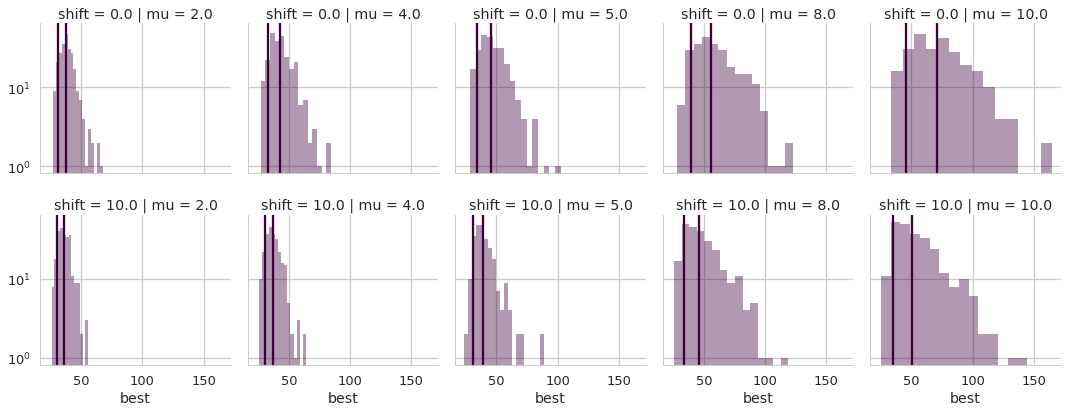

In [10]:
for ecut in ecuts:
    print ecut
    temp = signal_frame.query("ecut=={}".format(ecut))
    temp = temp.groupby(by=["trial", "shift", "mu"])["best"].sum().reset_index()
    grid = sns.FacetGrid(temp, row="shift", col="mu")
    grid.map(sns.distplot, "best", kde=False)
    grid.map(lambda x, **kwargs: plt.axvline(x.median(), **kwargs), "best")
    grid.map(lambda x, **kwargs: plt.axvline(x.quantile(0.1), **kwargs), "best")
    for ax in grid.axes.flatten():
        ax.semilogy(nonposy="clip")

## Evaluate TS

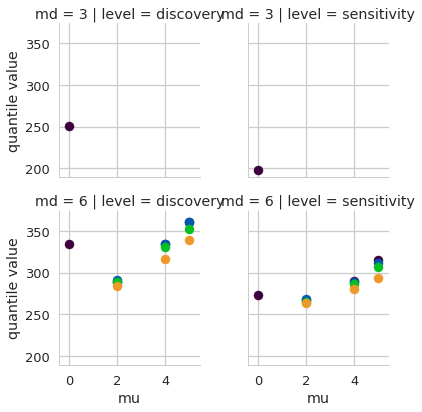

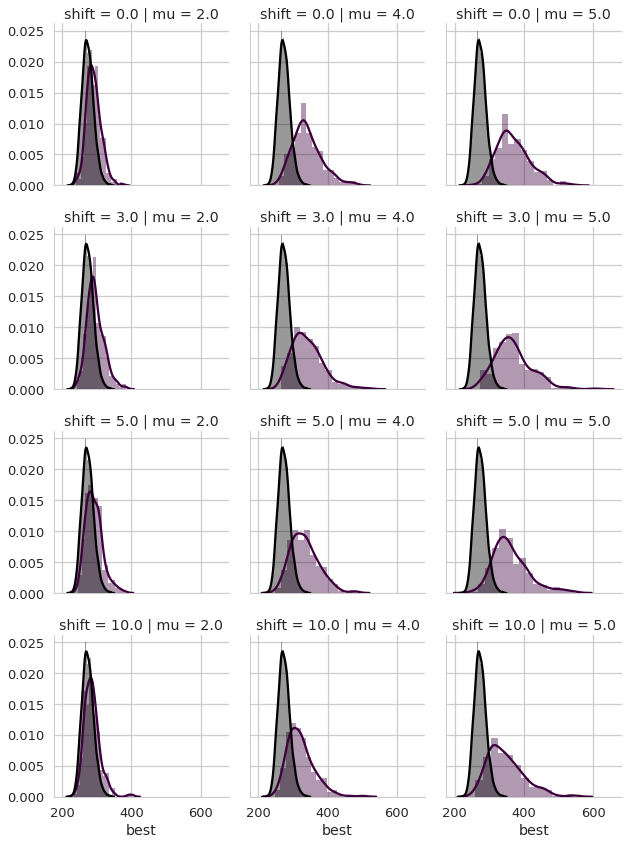

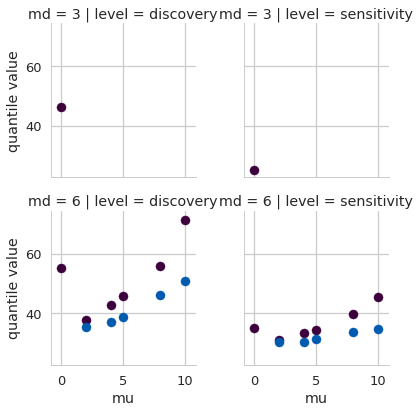

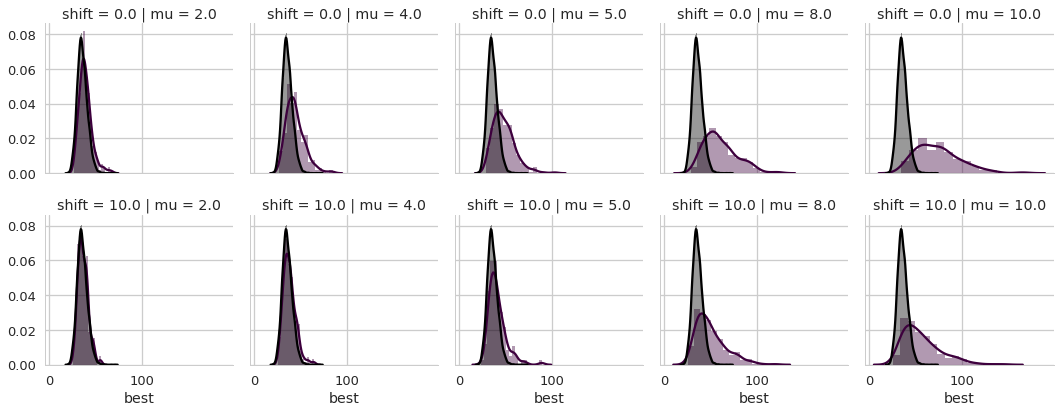

In [130]:
quantiles = pd.DataFrame({"type": ["background", "background", "signal", "signal"],
                       "level": ["sensitivity", "discovery", "sensitivity", "discovery"],
                       "vals": [erfc(0.)*0.5, 1.-erfc(3./np.sqrt(2))*0.5, 0.1, 0.5]})
quantiles = quantiles.pivot(index="type", columns="level", values="vals")


final_flux = []
final_n = dict()
plotting = True
saveplots = False

figure_counter = 3
ecuts = signal_frame.ecut.unique()
mdparams = signal_frame.md.unique()

for ecut in ecuts:
    valid = bg_frame.energy>=ecut
    best_bg = bg_frame.loc[valid].groupby(by=["trial", "md"])["best"].sum().reset_index()
    vals = best_bg.groupby("md")["best"].quantile(quantiles.loc["background"]).reset_index()
    vals = vals.rename(index=str, columns={"level_1": "level", "best": "quantile value"})
    vals["level"] = np.tile(quantiles.loc["background"].index, len(bg_frame.md.unique()))
    vals["mu"] =  0
    vals["mean n_inj"] =  0
    vals["shift"] =  0.
    """
    print vals.info()
    print vals #"""

    for md in mdparams:
        ## Evaluation of Test Statistic
        ## Use Percentiles, because most fits are unstable
        bins=10
        fitfunc = None
        s_frame = signal_frame.query("ecut=={} and md=={}".format(ecut, md))
        best_s = s_frame.groupby(by=["trial", "shift", "mu"])["best", "n_inj"].sum().reset_index()
        #print best_s.info()
        sig_vals = best_s.groupby(["shift", "mu"])["best"].quantile(quantiles.loc["signal"]).reset_index()
        sig_vals = sig_vals.rename(index=str, columns={"level_2": "level", "best": "quantile value"})
        sig_vals["level"] = np.tile(quantiles.loc["signal"].index, len(sig_vals)/2)
        sig_vals["md"] = md
        mean_ninj = best_s.groupby(["shift", "mu"])["n_inj"].mean().reset_index(drop=True)
        sig_vals["mean n_inj"] = np.repeat(mean_ninj.values, len(quantiles))
        vals = vals.append(sig_vals)
        """
        print vals.info()
        print vals #"""

        #"""
        grid = sns.FacetGrid(vals, col="level", hue="shift", row="md") #
        grid.map(plt.scatter, "mu", "quantile value")
        #"""
        grid = sns.FacetGrid(best_s, col="mu", row="shift")
        grid.map(sns.distplot, "best")
        grid.map(lambda x, **kwargs: sns.distplot(best_bg.loc[best_bg.md==md].best, **kwargs), "best", color="k")
        #grid.map(lambda x: plt.axvline())

In [ ]:
       
            vals[-1] -= bg_vals[qq]
            roots = np.roots(vals)
            #final_n[md][ecut][save_labels[qq]] = max(roots)
            #print r""+labels[qq]+" crossing point at mu={:1.0f}".format(max(roots))
            if False:
                plt.vlines(max(roots), min(ts), max(ts), 
                           label=labels[qq]+" crossing point at mu={:1.0f}".format(max(roots))) #roots[roots>min(mu)][0]
                plt.legend(loc=1)
                plt.xlabel("Sum of injected signal events")
                plt.ylabel("TS")
                if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_mu_crossing_fitted-gamma.png"))
                print figure_counter
                plt.show()
                
            ###### we also look at the base value of injected events, as cross check
            n_space = np.linspace(min(base_n), max(base_n))
            n_vals = np.polyfit(base_n, ts, 2)
            n_fit = np.poly1d(n_vals)
            if False:
                plt.figure(figure_counter)
                figure_counter += 1
                plt.plot(base_n, ts, marker="o", label="Raw Significances", lw=0)
                plt.plot(n_space, n_fit(n_space), linestyle="--", label="Significances fit", markersize=0)
                plt.hlines(bg_vals[qq], min(base_n), max(base_n))
                
            n_vals[-1] -= bg_vals[qq]
            n_roots = np.roots(n_vals)
            final_n[md][ecut][save_labels[qq]] = max(n_roots)
            print labels[qq]+" crossing point at n={:1.0f}".format(max(n_roots))
            if False:
                plt.vlines(max(n_roots), min(ts), max(ts), 
                           label=labels[qq]+" crossing point at n={:1.0f}".format(max(n_roots))) #roots[roots>min(mu)][0]
                plt.legend(loc=1)
                plt.xlabel("Sum of injected signal events")
                plt.ylabel("TS")
                if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_n_crossing_fitted-gamma.png"))
                print figure_counter
                plt.show()
            ######
            
            mean_flux_per_source = defaultdict()
            n_inj_per_map = defaultdict()
            for i,ak in enumerate(signals[md][ecut]):
                """
                here we have ALL signal contributions from one certain mu,
                this has shape N_MAPS x N_CR.
                the mean is then calculated over all N_CR contribution
                yielding a mean flux per source and map.
                we also sum over the whole number of injected events per map
                """
                mean_flux_per_source[ak] = np.mean(signals[md][ecut][ak]['n_inj'] * \
                                                   1./flux_spline(np.sin(signals[md][ecut][ak]['dec_inj'])), axis=-1)
                if np.ndim(signals[md][ecut][ak]['n_inj']) > 1:
                    n_inj_per_map[ak] = signals[md][ecut][ak]['n_inj'].sum(axis=-1)
                else:
                    n_inj_per_map[ak] = signals[md][ecut][ak]['n_inj']


            n_inj_sum = np.zeros(len(n_inj_per_map.keys()))
            flux_mean = np.zeros(len(mean_flux_per_source.keys()))
            for i,key in enumerate(n_inj_per_map):
                """
                Next, we average over each mu, 
                since one certain signal strength should yield one certain average flux
                """
                n_inj_sum[i]=np.mean(n_inj_per_map[key])
                flux_mean[i]=np.mean(mean_flux_per_source[key])

            
            idx = np.argsort(n_inj_sum)
            nspace = np.linspace(min(n_inj_sum), max(n_inj_sum), num=100)
            vals = np.polyfit(n_inj_sum[idx], flux_mean[idx], 1)
            fit = np.poly1d(vals)
            final_flux.append([ecut, fit(max(roots))])
            if False:
                plt.figure(figure_counter)
                figure_counter+=1
                plt.plot(n_inj_sum[idx], flux_mean[idx], marker="o")
                plt.plot(nspace, fit(nspace), linestyle="--", markersize=0)
                plt.vlines(max(roots), min(flux_mean[idx]), max(flux_mean[idx])) 
                plt.hlines(final_flux[-1][1], min(n_inj_sum), max(n_inj_sum), 
                           label=labels[qq]+r" crossing point at $\Phi_0$={:1.2e}".format(final_flux[-1][1]))
                plt.xlabel("Sum of injected signal events")
                plt.ylabel(r"$E^2 \cdot \mathrm{d}\Phi/\mathrm{d}E \; [\mathrm{TeV}/\mathrm{cm}^2/\mathrm{s}^2]$")
                plt.legend(loc=1)
                if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_phi_crossing_fitted-gamma.png"))
                print figure_counter
                plt.show()
            #except:
            #print "Calculating interpolations failed!"
        #break
    #break

In [ ]:
final_flux_percentile = np.copy(final_flux)
a = np.array(final_flux).T
b = np.repeat(mdparams, len(a[0])/len(mdparams))
b = b[np.newaxis]
c = np.concatenate((a, b), axis=0)
b = np.tile(bg_quantiles, len(a[0])/len(bg_quantiles))
b = b[np.newaxis]
c = np.concatenate((c, b), axis=0)

np.savetxt(os.path.join(savepath, "final_performance_fluxes_fit_gamma_ts_percentile.npy"), c.T)

In [ ]:
name = "{}_final-n.pickle".format(current_time)
with open(os.path.join(savepath, name), "wb") as f:
    pickle.dump(final_n, f, protocol=2)

## angular distance true vs fit

In [131]:
from ic_utils import angular_dist, angular_distance

In [300]:
distance_cut = 0.5
tempe = []
for ecut in ecuts:
    tempm = []
    for md in mdparams:
        sig = signal_frame.query("ecut=={} and md=={}".format(ecut, md))
        tempframes = []
        for name, nsig in sig.groupby(["trial", "shift", "mu"]):
            #ind_sources = []
            #for nd,nr in zip(nsig['dec'], nsig['ra']):
            nd = np.array(nsig['dec'], dtype=np.complex64)
            nd.imag = nsig['ra']
            #ind_sources.append(len(np.unique(np.round(nd, decimals=2))))
            ind_sources = len(np.unique(np.round(nd, decimals=2))) #np.array(ind_sources)
            # Calculate distance from one hotspot to the matching injected source
            distance = np.degrees(angular_distance([nsig['dec'], nsig['ra']],
                                                   [nsig['dec_inj'], nsig['ra_inj']])).flatten()
            # Count as "correct" if distance is smaller than distance_cut (e.g. 0.5deg)
            # This way we see which injected sources have actually been found
            # Normalize to total number of hotspots
            n1 = np.count_nonzero(distance<=distance_cut)*1./len(distance)

            # Calculate distance from all hotspots to all other injected sources
            # Then, find the minimum distance for each
            # This way, we see also hotspots that have been fitted multiple times
            distance = np.degrees(angular_dist(nsig['dec'], 
                                               nsig['ra'],
                                               nsig['dec_inj'], 
                                               nsig['ra_inj']))
            distance = np.min(distance, axis=-1).flatten()
            n2 = np.count_nonzero(distance<=distance_cut)*1./len(distance)
            #print md, nsig["mu"].unique(), nsig["shift"].unique(), ecut, ind_sources, n_cr[ecut], nsig["n_inj"].sum(), n1, n2
            tempframes.append(pd.DataFrame({
                "md": md,
                "mu": nsig["mu"].unique(),
                "shift": np.array(nsig["shift"].unique(), dtype=np.int),
                "ecut": ecut, 
                "nsources": ind_sources, 
                "ncr": n_cr[ecut], 
                "ninj": nsig["n_inj"].sum(),
                "dir_match": n1,
                "ov_match": n2
                }))
            #print tempframes
                
        tempm.append(pd.concat(tempframes))
    tempe.append(pd.concat(tempm))
hsp_frame = pd.concat(tempe)

print "done" 
hsp_frame["ncr-nsources"] = hsp_frame.ncr-hsp_frame.nsources

hsp_frame["ov-dir_match"] = hsp_frame.ov_match-hsp_frame.dir_match
#"""


done


In [82]:
name = "{}_signal_hsp-eval_dataframe.pickle".format(current_time)
print name
hsp_frame.to_pickle(os.path.join(savepath, name))

1526386172_signal_hsp-eval_dataframe.pickle


In [133]:
signal_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90980 entries, 0 to 3
Data columns (total 16 columns):
North       90980 non-null float64
South       90980 non-null float64
ra          90980 non-null float64
dec         90980 non-null float64
nsources    90980 non-null float64
gamma       90980 non-null float64
best        90980 non-null float64
ra_inj      90980 non-null float64
dec_inj     90980 non-null float64
n_inj       90980 non-null float64
energy      90980 non-null float64
mu          90980 non-null float64
ecut        90980 non-null int64
md          90980 non-null int64
trial       90980 non-null int64
shift       90980 non-null float64
dtypes: float64(13), int64(3)
memory usage: 11.8 MB


In [142]:
hsp_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5495 entries, 0 to 0
Data columns (total 11 columns):
dir_match       5495 non-null float64
ecut            5495 non-null int64
md              5495 non-null int64
mu              5495 non-null float64
ncr             5495 non-null int64
ninj            5495 non-null float64
nsources        5495 non-null int64
ov_match        5495 non-null float64
shift           5495 non-null float64
ncr-nsources    5495 non-null int64
diff_match      5495 non-null float64
dtypes: float64(6), int64(5)
memory usage: 675.2 KB


In [348]:
def blaplot(frame, x, y, ax, **kwargs):
    f = frame.groupby("shift")[y].mean().reset_index()
    xcount = np.bincount(f[x])
    xvals = f[x].values
    xpos = []
    c = []
    i=0
    for xc in xcount:
        xpos.extend(xc*[i])
        if xc>0:
            i+=1
    return plt.scatter(xpos, 
                       f[y],
                       **kwargs
                      )

dir_match
ov_match
ov-dir_match
dir_match
ov_match
ov-dir_match


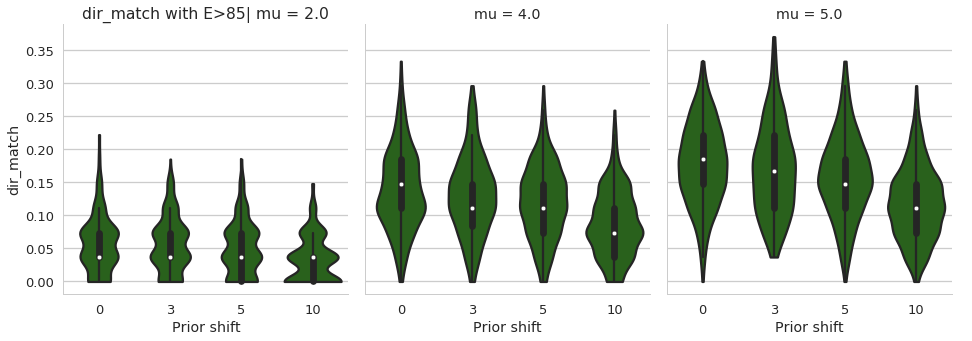

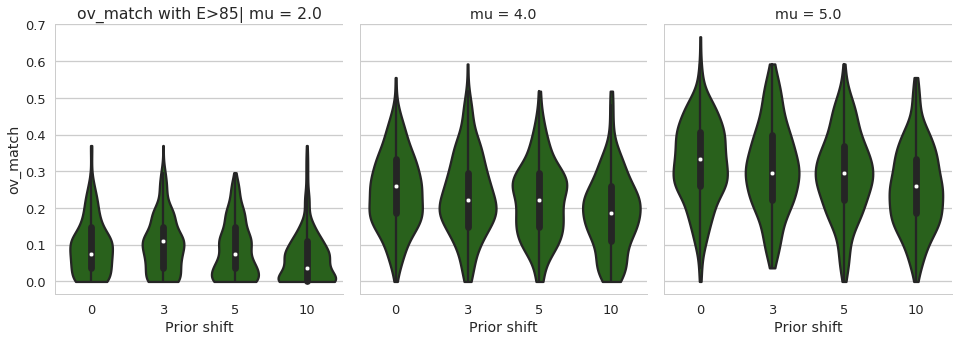

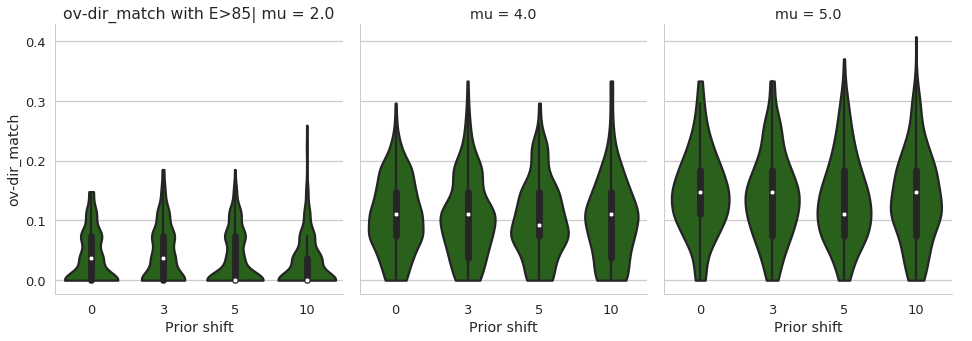

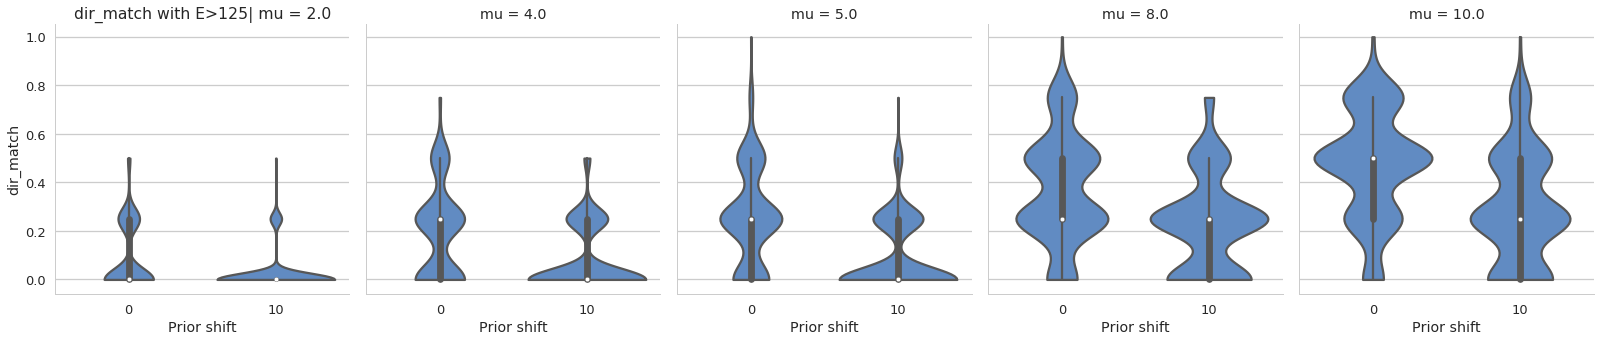

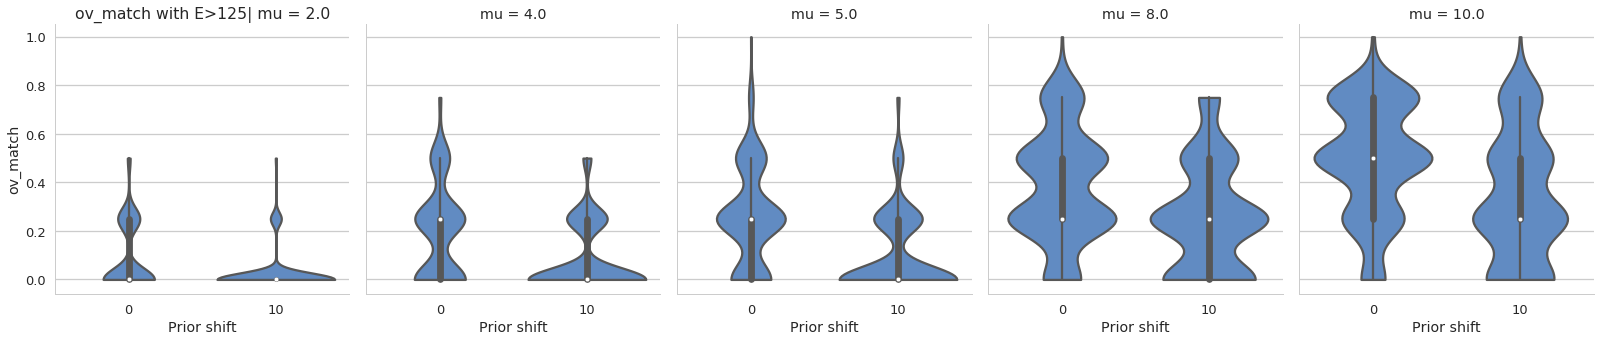

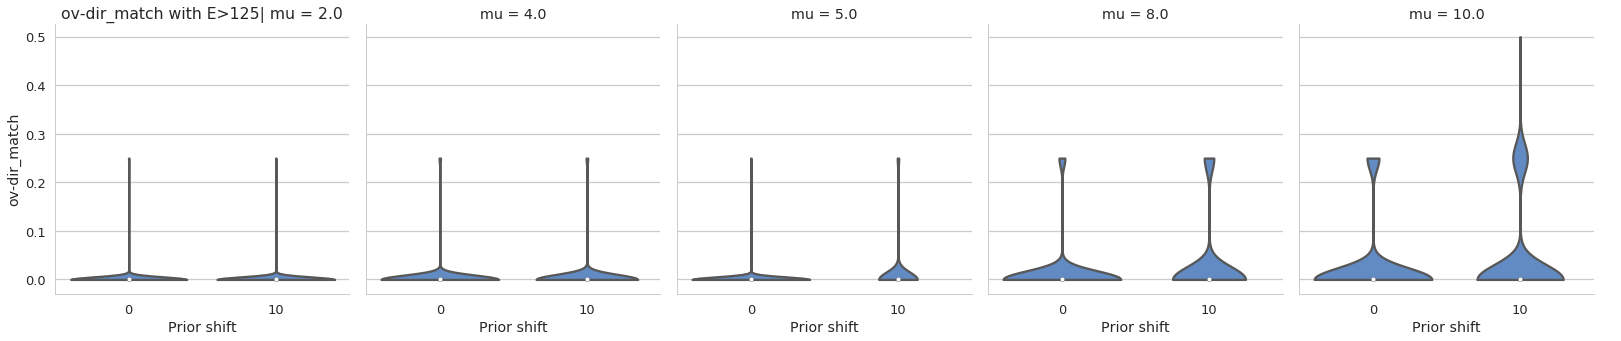

In [360]:
#ncolor = len(signals[3].keys())
ecuts = hsp_frame.ecut.unique()
colors = sns.cubehelix_palette(len(ecuts), start=.5, rot=1.5, dark=0.3, light=0.5, reverse=True, hue=1.5)
size = 5
aspect = 0.9
keys = ["dir_match", "ov_match", "ov-dir_match"]
for cc,ecut in enumerate(ecuts):
    for k in keys:
        print k
        temp = hsp_frame.loc[hsp_frame.ecut==ecut]
        #temp.info()
        grid = sns.FacetGrid(temp, 
                             col="mu", 
                             size=size, 
                             aspect=aspect
                            )
        grid = grid.map(sns.violinplot, 
                        "shift", 
                        k, 
                        cut=0,
                        fliersize=8,
                        color=colors[cc],
                        flierprops=dict(markerfacecolor=colors[cc])
                       )
        ax = grid.axes.flatten()[0]
        """ 
        grid = grid.map(blaplot,
                        frame=temp,
                        x="shift",
                        y=k,
                        ax=ax,
                        s=500,
                        marker="*",
                        color=colors[(cc+1)%len(ecuts)],
                        edgecolors="k",
                        linewidths=2.
                       )"""
        grid.add_legend(ncol=1)
        grid.set_xlabels("Prior shift") #("Injected events per source (horizon)")

        ax.set_title("{} with E>{}| {}".format(k, ecut, ax.get_title()))
        #grid.savefig(os.path.join(figurepath, "HSP_eval", "HSP_{}.png".format(k)))
plt.show()

## Flux limits

## Projected to 7 years

In [ ]:
#"""
tw=8
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/1.2)
mpl.rcParams.update(rcParams)
#"""
lw1 = 2.
lw2 = 5.
saveplots = True
erange = (min(ecuts)-5, max(ecuts)+5)

fig, ax1 = plt.subplots(1)
labels=["sensitivity", r"3$\sigma$ disc."] #, r"5$\sigma$ disc."] 
styles = defaultdict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="--"),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":"),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-")
             )
proj_styles = defaultdict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="--", alpha=0.75),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":", alpha=0.5),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-", alpha=0.25)
             )
kw = ["sens", "disc3", "disc5"]

# split flux into parts for each md value
ff = np.split(np.array(final_flux_percentile), len(mdparams))
md_labels = [r" $3^\circ$", r" $6^\circ$"] #\cdot E/EeV
# then loop over md values
for i,f in enumerate(ff):
    vals = [f[b::len(labels)] for b in xrange(len(labels))]
    for j,vv in enumerate(vals):
        #if j==1: continue
        vx, vy = vv[:, 0], vv[:, 1]
               
        ax1.plot(vx, np.log10(vy/np.sqrt(7)), 
                 label=labels[j]+md_labels[i],
                 **styles[kw[j]]
                ) 
        
plt.xlim(erange)
plt.ylim(-12.6, -11.3)

plt.grid(True)
ax1.set_xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
ax1.set_ylabel(r"$ \log (\frac{1}{N_{src}} \cdot \Phi_0 \; [\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}]$") #Threshold flux in 
plt.legend(ncol=2, loc=1)
plt.text(60, -11.6, r"Mean flux per source projected to 7 years $(1/\sqrt{7})$")

ax2 = ax1.twiny()
ax2.set_xlabel("Number of CR events")
ax2.set_xlim(erange)
ax2.set_xticks(ticks=ecuts)
ax2.set_xticklabels(labels=[n_cr[e] for e in ecuts])
ax2.grid(False)
if saveplots: plt.savefig(os.path.join(figurepath, "performance", "flux_comparison_scaled7yr_fitted_gamma.png"))
plt.show()

## performance vs $N_{CR}$

In [ ]:
hspa_sens = np.array([[1.0049827780489007, 2.642232833595364e-12],
[3.964114835393211, 1.318459051646478e-12],
[15.92871563625582, 7.027677347300487e-13],
[63.2219235736235, 3.7459803705646894e-13],
[252.4684748567044, 1.889859884329323e-13],
[995.7152464318317, 8.084371857801016e-14]])

hspa_ul = np.array([[1.0238777858597805, 3.1505858970762185e-12],
[4.013857361055144, 1.5721397314284798e-12],
[16.02991389607907, 8.566327926656099e-13],
[64.4149998273762, 4.82419861799373e-13],
[255.65905736516984, 2.487984516483817e-13],
[995.9886074749862, 1.1000287947343855e-13]])

hspa_sens = hspa_sens.T
hspa_ul = hspa_ul.T


In [ ]:
#"""
tw=8
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/1.2)
mpl.rcParams.update(rcParams)
#"""
lw1 = 2.
lw2 = 5.
saveplots = True
fig, ax1 = plt.subplots(1)
labels=["sensitivity", r"3$\sigma$ disc."] #, r"5$\sigma$ disc."] 
styles = defaultdict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="--"),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":"),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-")
             )
proj_styles = defaultdict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="--", alpha=0.75),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":", alpha=0.5),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-", alpha=0.25)
             )
kw = ["sens", "disc3", "disc5"]
"""
plt.plot(ecuts, np.log10(stefan_sens), color="0", label="PS sens. 7yr", **styles["sens"])
#plt.plot(ecuts, np.log10(stefan_disc), color="0.5", label="PS disc.", **styles["disc5"])
#"""
nsrc = [n_cr[e] for e in ecuts]
"""
ndiff = np.linspace(10, 500)
plt.plot(ndiff, np.log10(4.*np.pi*1.01*np.power(10,-18.+3+2*2.19)/ndiff), markersize=0,
           color="black", lw=lw1, linestyle="-", label=r"$\Phi_{\nu_\mu}/N_{CR}$ $\gamma=2.19$")
plt.plot(nsrc, np.log10(4.*np.pi*1.01*np.power(10,-18.+3+2*2.19)/nsrc*0.05), 
           color="gray", lw=lw1, linestyle="-.", label=r"Blazar stacking U.L.")
plt.plot(hspa_sens[0], np.log10(hspa_sens[1]), markersize=0,
           color=utils.colors[0], lw=lw1, linestyle=":", label=r"HSP sensitivity $\gamma=2$")
plt.plot(hspa_ul[0], np.log10(hspa_ul[1]), markersize=0,
           color=utils.colors[0], lw=lw1, linestyle="--", label=r"HSP U.L. $\gamma=2$")
#"""
# split flux into parts for each md value
ff = np.split(np.array(final_flux_percentile), len(mdparams))
md_labels = [r" $3^\circ$", r" $6^\circ$"] #\cdot E/EeV
# then loop over md values
for i,f in enumerate(ff):
    vals = [f[b::len(labels)] for b in xrange(len(labels))]
    for j,vv in enumerate(vals):
        #if j==1: continue
        vx, vy = vv[:, 0], vv[:, 1]
               
        ax1.plot([n_cr[e] for e in vx], np.log10(vy/np.sqrt(7)), 
                 label=labels[j]+md_labels[i],
                 **styles[kw[j]]
                ) 

        
plt.xlim(0.85, 200)
#plt.xlim(min(nsrc)-2, max(nsrc)+20)
plt.ylim(-12.6, -11.3)
plt.semilogx()

plt.grid(True)
ax1.set_xlabel("Number of CR events")
ax1.set_ylabel(r"$\log (\frac{1}{N_{src}} \cdot \Phi_0 \; [\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}])$")
ax1.set_xticks(ticks=nsrc)
ax1.set_xticklabels(labels=nsrc)
plt.legend(ncol=2, loc=1)
plt.title(r"Mean flux per source projected to 7 years $(1/\sqrt{7})$")
if saveplots: plt.savefig(os.path.join(figurepath, "performance", "flux_comparison_vs_NCR_scaled7yr_fitted_gamma.png"))
plt.show()

## total flux performance

In [ ]:
#"""
tw=8
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/1.2)
mpl.rcParams.update(rcParams)
#"""
lw1 = 2.
lw2 = 5.
saveplots = True
fig, ax1 = plt.subplots(1)
labels=["sensitivity", r"3$\sigma$ disc."] #, r"5$\sigma$ disc."] 
styles = defaultdict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="--"),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":"),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-")
             )
proj_styles = defaultdict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="--", alpha=0.75),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":", alpha=0.5),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-", alpha=0.25)
             )
kw = ["sens", "disc3", "disc5"]

# split flux into parts for each md value
ff = np.split(np.array(final_flux_percentile), len(mdparams))
md_labels = [r" $3^\circ$", r" $6^\circ$"] #\cdot E/EeV
# then loop over md values
for i,f in enumerate(ff):
    vals = [f[b::len(labels)] for b in xrange(len(labels))]
    for j,vv in enumerate(vals):
        #if j==1: continue
        vx, vy = vv[:, 0], vv[:, 1]
               
        ax1.plot(vx, np.log10([vy[ind]/np.sqrt(7)*n_cr[vx[ind]] for ind,_ in enumerate(vx)]), 
                 label=labels[j]+md_labels[i], #+" projected to 7yr", 
                 **styles[kw[j]]
                ) 
plt.hlines(np.log10(4.*np.pi*1.01*np.power(10,-18.+3+2*2.19)), min(ecuts)-5, max(ecuts)+5, 
           color="black", lw=lw1, linestyle="--", label=r"$4\pi \cdot \Phi_{0}^{\nu_\mu} @ 1\mathrm{TeV}$")
"""plt.hlines(np.log10(4.*np.pi*0.75*np.power(10,-18.+3+2*2)), min(ecuts), max(ecuts), 
           color="black", lw=lw1, linestyle="-", label=r"all-sky $\nu_\mu E^{-2}$ flux ")
plt.hlines(np.log10(4.*np.pi*1.01*np.power(10,-18.+3+2*2.19)*0.05), min(ecuts), max(ecuts), 
           color="gray", lw=lw1, linestyle="-.", label=r"Blazar stacking U.L.")"""
plt.xlim(erange)
plt.ylim(-12., -9.4)

plt.grid(True)
ax1.set_xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
ax1.set_ylabel(r"$\log (\Phi_0 \; [\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}])$")
plt.legend(ncol=1, loc=1)
plt.text(65, -11.9, r"Mean total flux projected to 7 years $(1/\sqrt{7})$")

ax2 = ax1.twiny()
ax2.set_xlabel("Number of CR events")
ax2.set_xlim(erange)
ax2.set_xticks(ticks=ecuts)
ax2.set_xticklabels(labels=[n_cr[e] for e in ecuts])
ax2.grid(False)
if saveplots: plt.savefig(os.path.join(figurepath, "performance", "total_flux_comparison_scaled7yr_fitted_gamma.png"))
plt.show()

## Single year

## Comparison fit and percentile

In [ ]:
#"""
tw=8
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/1.2)
mpl.rcParams.update(rcParams)
#"""
lw1 = 2.
lw2 = 5.
saveplots = True
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

styles = defaultdict(sens=dict(lw=lw2, markersize=15, linestyle="--"),
              disc3=dict(lw=lw2, markersize=15, linestyle=":"),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-")
             )
kw = ["sens", "disc3", "disc5"]
keys = ["sensitivity", r"$3\sigma$ discovery", r"$5\sigma$ discovery"]

# split flux into parts for each md value
ff = np.split(np.array(final_flux_fit), len(mdparams))
#labels=["sens. fit", r"3$\sigma$ disc. fit", r"5$\sigma$ disc. fit"]
md_labels = [r" $3^\circ$", r" $6^\circ$"] #\cdot E/EeV #r" $3^\circ$", 
# then loop over md values
for i,f in enumerate(ff):
    vals = [f[b::3] for b in xrange(3)]
    for j,vv in enumerate(vals):
        if j==2: continue
        vx, vy = vv[:, 0], vv[:, 1]
        #plt.subplot(j)
        ax[j].plot(vx, np.log10(vy), 
                 label="Fit"+md_labels[i], 
                 #**styles[kw[j]]
                )
        
# split flux into parts for each md value
ff = np.split(np.array(final_flux_percentile), len(mdparams))
labels=["sens. percentile", r"3$\sigma$ disc. percentile"] #, r"5$\sigma$ disc. percentile"]
# then loop over md values
for i,f in enumerate(ff):
    vals = [f[b::2] for b in xrange(2)]
    for j,vv in enumerate(vals):
        #if j==2: continue
        vx, vy = vv[:, 0], vv[:, 1]
        #plt.subplot(j)
        ax[j].plot(vx, np.log10(vy), 
                 label="Percentile"+md_labels[i], 
                 #**styles[kw[j]]
                )
        ax[j].set_xlim(erange)
        ax[j].set_xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
        
        ax[j].set_ylim(-12.2, -11.)
        ax[j].set_title("Mean {} flux per source 1 year".format(keys[j]))
        ax[j].legend(ncol=2, loc=2)

ax[0].set_ylabel(r"$\log (\frac{1}{N_{src}} \cdot \Phi_0 \; [\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}])$")

"""
plt.subplot(0)
#plt.plot(ecuts, np.log10(stefan_sens), color="0", label="PS sens.", **styles["sens"])
plt.xlim(erange)
plt.grid(True)
plt.xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
plt.ylabel(r"$\log (\frac{1}{N_{src}} \cdot \Phi_0 \; [\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}])$") #Threshold flux in 
plt.legend(ncol=2, loc=1)
plt.title("Mean flux per source 1 year")
#plt.ylim(-12.1, -11.6)
#if saveplots: plt.savefig(os.path.join(figurepath, "performance", "flux_comparison_7yr_fit_vs_percentile_sens.png"))



plt.subplot(1)
#plt.plot(ecuts, np.log10(stefan_disc), color="0.5", label="PS disc.", **styles["disc5"])
#plt.ylim(-11.9, -11.2)
plt.xlim(erange)
plt.grid(True)
plt.xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
plt.ylabel(r"$\log (\frac{1}{N_{src}} \cdot \Phi_0 \; [\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}])$") #Threshold flux in 
plt.legend(ncol=2, loc=1)
plt.title("Mean flux per source 1 year")
#if saveplots: plt.savefig(os.path.join(figurepath, "performance", "flux_comparison_7yr_fit_vs_percentile_3disc.png"))
    
plt.subplot(2)
#plt.plot(ecuts, np.log10(stefan_disc), color="0.5", label="PS disc.", **styles["disc5"])
#plt.ylim(-11.8, -11.2)
plt.xlim(erange)
plt.grid(True)
plt.xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
plt.ylabel(r"$\log (\frac{1}{N_{src}} \cdot \Phi_0 \; [\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}])$") #Threshold flux in 
plt.legend(ncol=2, loc=1)
plt.title("Mean flux per source 1 year")
#if saveplots: plt.savefig(os.path.join(figurepath, "flux_fit_5disc.png"))
#"""
if saveplots: plt.savefig(os.path.join(figurepath, "performance", "flux_comparison_7yr_fit_vs_percentile.png"))
plt.show()